In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import plotly.express as px

In [2]:
file_path = "Results_21Mar2022.csv"
data = pd.read_csv(file_path)

In [3]:
env_columns = ['mean_ghgs', 'mean_land', 'mean_watscar', 'mean_eut', 'mean_bio', 'mean_watuse', 'mean_acid']
group_columns = ['diet_group', 'sex', 'age_group']

# Aggregate data by diet_group
agg_data = data.groupby('diet_group')[env_columns].mean().reset_index()

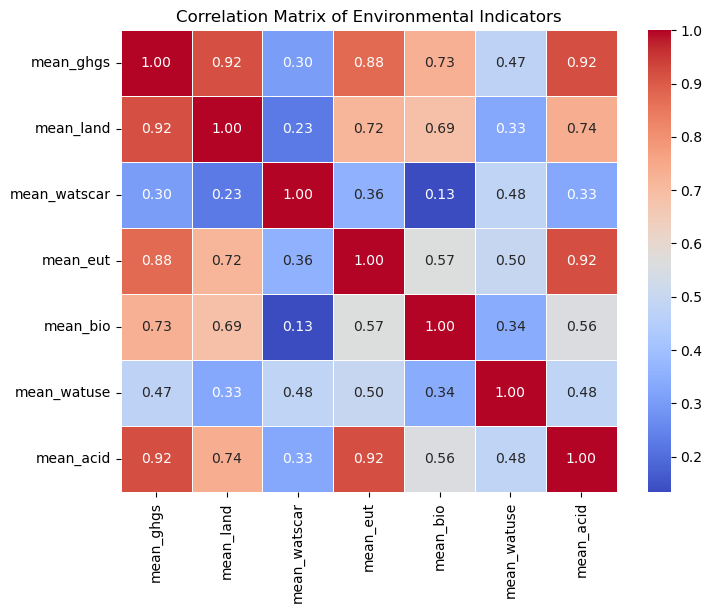

In [4]:
correlation_matrix = data[env_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Environmental Indicators')
plt.savefig('heatmap_matrix.png')
plt.show()

## Radar chart

In [6]:
from sklearn.preprocessing import MinMaxScaler

/var/folders/0r/3bp7fvfj7_54s3p_nwy63n100000gn/T/ipykernel_65395/2346605172.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


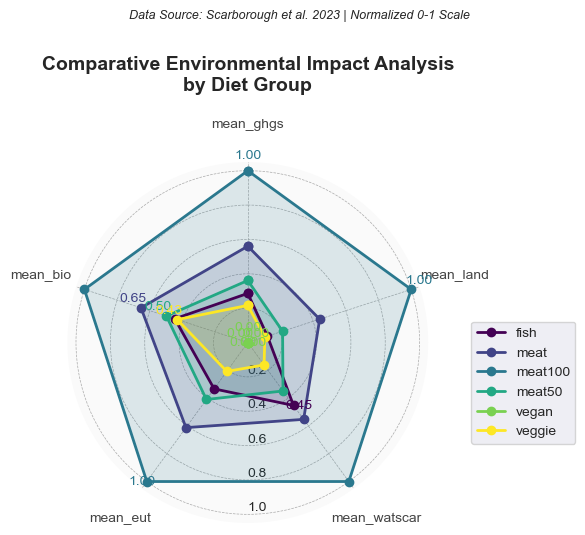

In [7]:
def plot_enhanced_radar_chart(df, diet_groups, cols, interactive=False):
    scaler = MinMaxScaler()
    scaled_data = df[cols].copy()
    scaled_data[cols] = scaler.fit_transform(df[cols])
    plt.style.use('seaborn-darkgrid')
    colors = plt.cm.viridis(np.linspace(0, 1, len(diet_groups)))
    labels = np.array(cols)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    for idx, group in enumerate(diet_groups):
        values = scaled_data.loc[df['diet_group'] == group, cols].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=colors[idx], linewidth=2,
                linestyle='solid', label=group, marker='o', markersize=6)
        ax.fill(angles, values, color=colors[idx], alpha=0.15)

        for angle, value, label in zip(angles[:-1], values[:-1], labels):
            if value == max(values[:-1]):  
                ax.text(angle, value + 0.05, f'{value:.2f}', 
                        color=colors[idx], ha='center', va='bottom')
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(180)
    plt.xticks(angles[:-1], labels, fontsize=10, color='#444444')
    ax.tick_params(axis='x', pad=20) 
    ax.grid(color='#AAAAAA', linestyle='--', linewidth=0.5)
    ax.set_facecolor('#FAFAFA') 
    
    plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.2), frameon=True)
    plt.title('Comparative Environmental Impact Analysis\nby Diet Group', 
             pad=20, fontsize=14, fontweight='bold')
    
    plt.figtext(0.5, 0.95, 
                'Data Source: Scarborough et al. 2023 | Normalized 0-1 Scale',
                ha='center', fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.savefig('enhanced_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
env_columns = ['mean_ghgs', 'mean_land', 'mean_watscar', 'mean_eut', 'mean_bio']
plot_enhanced_radar_chart(agg_data, agg_data['diet_group'].unique(), env_columns)

## Treemap

In [10]:
data.columns = data.columns.str.strip().str.lower()
melted_data = data.melt(
    id_vars=["diet_group"],
    value_vars=[
        "mean_ghgs", "mean_land", "mean_watscar",
        "mean_eut", "mean_bio", "mean_watuse", "mean_acid"
    ],
    var_name="Indicator",
    value_name="Impact"
)

melted_data["Impact"] = melted_data["Impact"] ** 0.08  # applies square root scaling, magnifying small values

# Treemap
fig = px.treemap(
    melted_data,
    path=["diet_group", "Indicator"],  
    values="Impact",
    color="Impact",
    color_continuous_scale="Viridis",  
    range_color=[melted_data["Impact"].min(), melted_data["Impact"].quantile(0.85)],  
    title="Treemap of Environmental Impact by Diet Group"
)

fig.update_traces(
    textinfo="label+percent parent+value",  
    hovertemplate="<b>%{label}</b><br>Impact: %{value:.2f}"
)


fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    font=dict(family="Arial, sans-serif", size=14),
    coloraxis_colorbar=dict(title="Mean Impact", tickvals=[10, 1000, 10000, 1000000]),
    treemapcolorway=["#d9d6c3", "#d1c7b7", "#f2eada", "#d3d7d4", "#999d9c"],  # color
)

fig.write_image("treemap.png")

fig.show()